In [1]:
import time
import math
import pyaudio
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
import spiUtils as su
import spidev

### pyAudio functions

In [2]:
#class for writing to speaker
class Output:
    pa = None;
    s  = None;
    #call this function to open output and create stream
    def __init__(self,rate=8000):
        """
        Output class constructor initializes and opens pyAudio output
        stream. Allows sending audio data to an audio output device via python.
        """
        #print ("init_audio: Create PyAudio object")
        self.pa = pyaudio.PyAudio()
        #print ("init_audio: Open stream")
        self.s = self.pa.open(output=True,
                channels=1,
                rate=rate,
                format=pyaudio.paInt16,
                output_device_index=0)
        print ("audio stream initialized")

    def close_audio(self):
        """
        Output class destructor closes and destructs output object
        and associated pyAudio stream.
        """
        #print ("close_audio: Closing stream")
        self.s.close()
        print ("close_audio: Terminating PyAudio Object")
        self.pa.terminate()
        
    #create a numpy array of a given freqeuncy    
    def customNote(self, freq, len, amp=5000, rate=8000, 
            vibrato=0,vibratoFreq=0,
            trembelo=0, trembeloFreq=0):
        """
        Creates a uniform note (a sinusoidal waveform of with characteristics specified
        by function parameters) returned as a 16bit integer numpy array.
        """
        # get time array
        t = np.linspace(0,len,len*rate)
        # create a modulated tone
        data = np.sin(2*np.pi*(freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))*t)\
               *(amp+trembelo*np.cos(2*np.pi*t*trembeloFreq))
        return data.astype(np.int16) # two byte integers

    # overloaded note function that derives note params from list of pot readings
    def note(self, freq, pot_readings):
        """
        Creates a uniform note (a sinusoidal waveform of with characteristics specified
        by function parameters) returned as a 16bit integer numpy array.
        """
        len=1
        RATE = 8000
        amp = pot_readings[0]*4000 + 3000 # [3000, 7000]
        vibrato = pot_readings[1] # [0, 1]
        vibratoFreq = pot_readings[2]*100 # [0, 100]
        
        #trembelo = pot_readings[3] # [0, 1]
        trembelo = 1
        trembeloFreq = pot_readings[4]*100 # [0, 100]
        print(amp, vibrato, vibratoFreq, trembelo, trembeloFreq)
        # get time array
        t = np.linspace(0,len,len*RATE)
        # create a modulated note
        data = np.sin(2*np.pi*(freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))*t)\
               *(amp+trembelo*np.cos(2*np.pi*t*trembeloFreq))
        return data.astype(np.int16) # two byte integers
    
    #write numpy array to stream
    def tone(self, note):
        """
        Takes a 16bit integer numpy array, representing a note, as an argument
        and plays the represented note via the pyAudio stream.
        """
        # generate sound
        self.s.write(note)
    
    #add two numpy arrays together
    def add_note(self, note1, note2):
        """
        combines two notes (of the same length) element-wise to produce a new note.
        """
        return note1 + note2

### signal processing functions

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=1):
    """
    Uses linear interpolation to upsample numpy arrays to a uniform shape
    to accomodate the pyAudio stream parameters.
    """
    SAMP_DURATION = float(SAMP_DURATION) # seconds
    data_len = len(data)
    fs = data_len / SAMP_DURATION
    xp = np.arange(data_len)
    x = np.linspace(0, data_len, 8000*int(SAMP_DURATION))
    upsamp_data = np.interp(x, xp, data) * MAG_SCALAR
    return upsamp_data

def increaseFreq():
    '''
    increments the global frequency value, if the value if not at maximum
    '''
    MAX_FREQ = 523.25
    global freq
    global keys_list
    if freq < MAX_FREQ:
        freq_idx = keys_list.index(freq)
        freq = keys_list[freq_idx+1]
        
def decreaseFreq():
    '''
    decrements the global frequency value, if the value if not at minimum
    '''
    MIN_FREQ = 261.63
    global freq
    global keys_list
    if freq > MIN_FREQ:
        freq_idx = keys_list.index(freq)
        freq = keys_list[freq_idx-1]
    

### Potentiometer SPI sampling functions

In [4]:
# GPIO setup
GPIO.setmode(GPIO.BCM)

# ADC setup
ADC2 = 4
GPIO.setup(ADC2, GPIO.OUT)

ADC3 = 5
GPIO.setup(ADC3, GPIO.OUT)

# frequency button setup
up_freq_button = 23
GPIO.setup(up_freq_button, GPIO.IN, pull_up_down=GPIO.PUD_DOWN)

down_freq_button = 25
GPIO.setup(down_freq_button, GPIO.IN, pull_up_down=GPIO.PUD_DOWN)    

def initSpi():
    spi1 = spidev.SpiDev()       # Create a new spidev object
    spi1.open(0,0)
    spi1.max_speed_hz = int(20e5) # Set clock speed to 

    spi2 = spidev.SpiDev()       # Create a new spidev object
    spi2.open(0,1)
    spi2.max_speed_hz = int(20e5) # Set clock speed to ___
    
    GPIO.output(ADC2, True)
    GPIO.output(ADC3, True)
    
    return spi1, spi2

def readPiezo(spi1):
    config = [0b01101000, 0] # Measure from channel 0
    myBytes = spi1.xfer2(config) # Send and get array of 2 bytes from ADC
    myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
    return myData

def readPot(input, spi1, spi2):
    if(input==0):
        config = [0b01111000, 0] # Measure from channel 1
        myBytes = spi1.xfer2(config)             # Send and get array of 2 bytes from ADC
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData   
     
    if(input==1):
        config = [0b01101000, 0] # Measure from channel 0
        GPIO.output(ADC2, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC2, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==2):
        config = [0b01111000, 0] # Measure from channel 1
        GPIO.output(ADC2, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC2, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==3):
        config = [0b01101000, 0] # Measure from channel 0
        GPIO.output(ADC3, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC3, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData
    
    if(input==4):
        config = [0b01111000, 0] # Measure from channel 1
        GPIO.output(ADC3, False)
        myBytes = spi2.xfer2(config)             # Send and get array of 2 bytes from ADC
        GPIO.output(ADC3, True)
        myData = (myBytes[0] << 8) | myBytes[1] # Convert returned bytes to integer value
        return myData

def normalizePotVal(val):
    '''
    Takes a potentiometer reading and returns a normalized value [0, 1]
    '''
    POT_MAX = 512.0
    POT_MIN = 0.0
    norm_val = (val - POT_MIN) / (POT_MAX - POT_MIN)
    return norm_val

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  if __name__ == '__main__':


### tone library

In [5]:
keys = {
    "c4": 261.63,
    "d4": 293.66,
    "e4": 329.63,
    "f4": 349.23,
    "g4": 392,
    "a4": 440,
    "b4": 493.88,
    "c5": 523.25
}

keys_list = [
    261.63,
    293.66,
    329.63,
    349.23,
    392,
    440,
    493.88,
    523.25
]

In [6]:
# allocate a thread for listening to up button (increase freq)
GPIO.add_event_detect(up_freq_button,
                      GPIO.RISING,
                      callback=increaseFreq,
                      bouncetime=200)
# allocate a thread for listening to down button (decrease freq)
GPIO.add_event_detect(down_freq_button,
                      GPIO.RISING,
                      callback=decreaseFreq,
                      bouncetime=200)

In [7]:
try:
    
    # set the starting frequency
    freq = keys_list[0]

    # numpy array for storing piezo readings
    nDATA  = 1000 # num of datapoints in a packet
    dPIEZO = np.zeros(nDATA,dtype='float')
    
    DIG_THRESH = 0 # signature for digaridoo playing

    # initialize serial peripheral interfaces for potentiometers
    spi1, spi2 = initSpi()
    NUM_POTS = 5 # number of potentiometer values
    pot_vals = [0]*NUM_POTS # for storing potentiometer readings
    
    # instantiate pyAudio output
    out_stream = Output()
    
    while True:
        # get a packet of data from the piezo
        for i in range(nDATA):
            dPIEZO[i] = readPiezo(spi1) #PIEZO element
        # if the data has a signature of the resonating digeridoo
        if np.amax(dPIEZO) > DIG_THRESH:
            # collect all of the potentiometer values
            for i in range(NUM_POTS):
                # get a potentiometer reading
                pot_val = readPot(i, spi1, spi2)
                # normalize it and add it to the list
                pot_vals[i] = normalizePotVal(pot_val)
            print(pot_vals)
            # generate an output signal
            note = out_stream.note(freq, pot_vals)
            # play the signal
            out_stream.tone(note)
            
except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")

finally:
    print("Done!")
    out_stream.close_audio();           

audio stream initialized
[0.0, 0.439453125, 0.4921875, 0.013671875, 0.109375]
3000.0 0.439453125 49.21875 1 10.9375
[0.0, 0.44140625, 0.490234375, 0.013671875, 0.109375]
3000.0 0.44140625 49.0234375 1 10.9375
[0.0, 0.435546875, 0.490234375, 0.013671875, 0.109375]
3000.0 0.435546875 49.0234375 1 10.9375
[0.0, 0.4453125, 0.49609375, 0.013671875, 0.111328125]
3000.0 0.4453125 49.609375 1 11.1328125
[0.0, 0.44140625, 0.48828125, 0.013671875, 0.109375]
3000.0 0.44140625 48.828125 1 10.9375
[0.0, 0.439453125, 0.4921875, 0.013671875, 0.109375]
3000.0 0.439453125 49.21875 1 10.9375
[0.0, 0.4453125, 0.498046875, 0.013671875, 0.107421875]
3000.0 0.4453125 49.8046875 1 10.7421875
[0.0, 0.4375, 0.490234375, 0.013671875, 0.109375]
3000.0 0.4375 49.0234375 1 10.9375
[0.0, 0.439453125, 0.4921875, 0.013671875, 0.111328125]
3000.0 0.439453125 49.21875 1 11.1328125
[0.0, 0.43359375, 0.490234375, 0.013671875, 0.109375]
3000.0 0.43359375 49.0234375 1 10.9375
[0.0, 0.4375, 0.48828125, 0.013671875, 0.109375

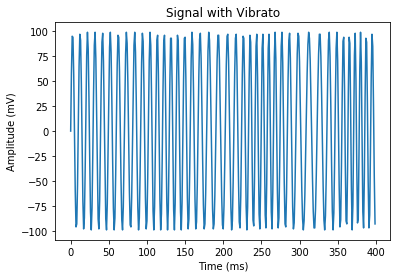

In [28]:
data = out_stream.customNote(100, 1, amp=100, rate=1000, vibrato=2, vibratoFreq=8, trembelo=0, trembeloFreq=0)
plt.plot(data[0:400])
plt.title("Signal with Vibrato")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (mV)")
plt.savefig('vibrato.jpg')
plt.show()

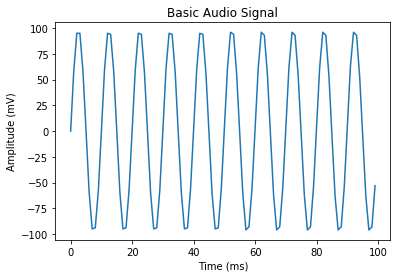

In [33]:
data = out_stream.customNote(100, 1, amp=100, rate=1000, vibrato=0, vibratoFreq=0, trembelo=0, trembeloFreq=0)
plt.plot(data[0:100])
plt.title("Basic Audio Signal")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (mV)")
plt.savefig('basic.jpg')
plt.show()

In [9]:
'''for i in range(5):
    plt.plot(data[i])
    plt.show()'''

'for i in range(5):\n    plt.plot(data[i])\n    plt.show()'

In [10]:
'''
data = np.load("dig22Apr19.npy")
upsamp_data = interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=150)

# play the output signal
out_stream.tone(out_stream.note(keys['d4'], 1))
out_stream.tone(out_stream.note(keys['e4'], 1))
out_stream.tone(out_stream.note(keys['f4'], 1))
out_stream.tone(out_stream.note(keys['g4'], 1))
out_stream.tone(out_stream.note(keys['a4'], 1))
out_stream.tone(out_stream.note(keys['b4'], 1))
out_stream.tone(out_stream.note(keys['c5'], 1))
'''

'\ndata = np.load("dig22Apr19.npy")\nupsamp_data = interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=150)\n\n# play the output signal\nout_stream.tone(out_stream.note(keys[\'d4\'], 1))\nout_stream.tone(out_stream.note(keys[\'e4\'], 1))\nout_stream.tone(out_stream.note(keys[\'f4\'], 1))\nout_stream.tone(out_stream.note(keys[\'g4\'], 1))\nout_stream.tone(out_stream.note(keys[\'a4\'], 1))\nout_stream.tone(out_stream.note(keys[\'b4\'], 1))\nout_stream.tone(out_stream.note(keys[\'c5\'], 1))\n'